In [1]:
import numpy as np
from torch.autograd import Variable
import torch
import random
from typing import List, Callable, Iterable
import matplotlib.pyplot as plt
import time
import numdifftools as nd

seed = 999
torch.manual_seed(seed)
random.seed(seed)

## Gradient-Filter-based Distributed Gradient Descent

In [6]:

def CGEFilter(gradients: List[torch.Tensor], n: int, f: int):
    assert (f <= n)
    tmp = sorted(gradients, key=lambda x: x.norm())
    return sum(tmp[:n-f])


def decision(p):
    '''Make the decision with probability p'''
    return random.random() < p




In [7]:
agents_cost = [
    lambda X: sum((X-1000)**2),
    lambda X: sum((X-5)**2),
    lambda X: sum((X+7)**2),
    lambda X: sum(X**2) - sum(X),
    lambda X: X[0]**2+X[-1]**2,
    # lambda X: sum(torch.cos(X)),
]


dim = 10 # dimension of x
step_size = 0.1 # Eta
num_agents = len(agents_cost) # number of agents
num_faulty = 0 # current number of faulty agents
max_num_faulty = num_agents - 2
fault_rate = 0.0


X = torch.randint(low=-10000, high=10000, size=(dim, )).to(torch.float)
# X = torch.rand((dim, ))
losses = []
for _ in range(10):
    time.sleep(0.5)
    gradients = []
    faulty_agents = []
    X = Variable(X, requires_grad=True)
    for i, cost in enumerate(agents_cost):
        if cost is None:
            continue
        y = cost(X)
        y.backward()
        is_failed = decision(fault_rate)
        if num_faulty < max_num_faulty and is_failed:
            num_faulty += 1
            faulty_agents.append(i)
        else:
            gradients.append(X.grad.clone())
        X.grad.zero_()
    
    for index in faulty_agents:
        agents_cost[index] = None
        
    if len(faulty_agents) > 0:
        print("\nfaulty agents:", faulty_agents)
    
    new_grad = CGEFilter(gradients, num_agents, num_faulty)
    X = X.data - step_size*new_grad
    step_size *= 0.98 # diminishing step size

    loss = 0.0
    for cost in agents_cost:
        if cost is not None:
            loss += cost(X)
    print(f'step: {_} | loss: {loss.item():4f} | grad norm: {new_grad.norm().item():4f} | step size: {step_size:6f}', end='\r')
    losses.append(loss.item())

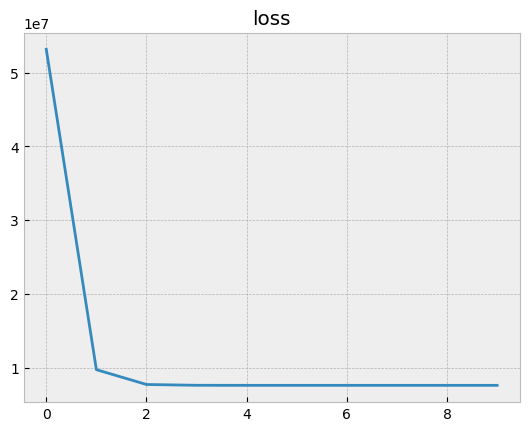

In [51]:
plt.style.use('bmh')
plt.plot(losses)
plt.title('loss')
plt.show()

## Linearization Method

In [5]:
import scipy.optimize as opt
from scipy.optimize import LinearConstraint, NonlinearConstraint, Bounds

In [6]:

def Gradient(func: Callable, X):
        return nd.Gradient(func)(X)
def Derivative(func: Callable, X, order):
        return nd.Derivative(func, n=order)(X)


In [7]:
'''
δ, subscript of I(X), should be non-negative
inf implies I_δ(X) == I(X)
'''
DELTA = np.inf 
N = 1
EPSILON = 0.5



In [12]:
obj = lambda X: (X[1]**2)-3
cons =[
    lambda X: 0.0, # the assumption on the top of page 44
    lambda X: 10**X[0] -0.1,
    lambda X: 10**X[1] -0.001,
    # lambda X: (X**2).sum() - 1,   # x^2 + y^2 + 1
    # lambda X: abs(X[0]) + abs(X[1]) - 1,
    # lambda X: X[0]**3 + X[1]**2, # x^3 + y^2
]

# initial guess
X = np.array([3.0, -2.0])
print(X)

# real answer
res = opt.minimize(obj, X, constraints=[NonlinearConstraint(i, -np.inf, 0) for i in cons])
res

[ 3. -2.]


     fun: 6.0
     jac: array([ 0., -6.])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-1., -3.])

In [13]:
# Our ans
positions = [X.copy()]
num_iterate = 50

def FindP():
    '''Find I_δ(X)'''
    F = lambda X: max([f(X) for f in cons])
    I_delta = []
    for i, f_i in enumerate(cons):
        if f_i(X) >= F(X) - DELTA:
            I_delta.append(i)
    '''approximate objective'''
    quad_obj = lambda p: np.dot(Gradient(obj, X), p) + 0.5*np.dot(p, p)

    '''approximate constraints'''
    grad_of_cons = []
    val_of_cons = []
    for i in I_delta:
        val_of_cons.append(cons[i](X))
        grad_of_cons.append(Gradient(cons[i], X))

    # linear_cons = [np.dot(grad, p) + val for grad, val in zip(grad_of_cons, val_of_cons)]

    res = opt.minimize(quad_obj, X, constraints=[LinearConstraint(grad, -np.inf, -val) for grad, val in zip(grad_of_cons, val_of_cons)])
    if not res.success:
        print(res)
        raise(BaseException)
    p = (res.x) # solution of the quadratic programming problem
    return p, F

# Optimization 
for _ in range(num_iterate):
    p, F = FindP()
    '''gradient filter'''
    '''g_i(w) = f_i(x + w * p), w is scalar '''
    gd_filter_threshold = 10
    faulty_constraints = []
    # print(_)
    for i in range(len(cons)):
        g_i = lambda w: cons[i](X + w*p)
        # print(f'{Derivative(g_i, 0, order=2)}_{X}')
        if Derivative(g_i, 0, order=2) > gd_filter_threshold:
            faulty_constraints.append(i)
    if (len(faulty_constraints) > 0):  # update honest constraints
        # tmp = []
        print(faulty_constraints)
        # for idx in range(len(cons)):
        #     if idx not in faulty_constraints:
        #         tmp.append(cons[idx])
        # cons = tmp
    p, F = FindP()
    assert(len(cons) == 3)
    alpha = 1
    while obj(X + alpha*p) + N*F(X + alpha*p) > obj(X) + N*F(X) - alpha*EPSILON*np.dot(p, p):
        alpha /= 2

    X += alpha*p
    positions.append(X.copy())
    print(f'obj: {obj(X)}, X: ({X[0]:4f}, {X[1]:4f}), alpha: {alpha}, |p|: {sum(p**2):4f}', end='\n')
    # time.sleep(1)
    # break


0
0.0_[ 3. -2.]
999.8000099998425_[ 3. -2.]
0.008100000000013232_[ 3. -2.]
[1]
obj: 2.716235609431113, X: (2.565749, -2.390865), alpha: 1, |p|: 0.341349
1
0.0_[ 2.56574895 -2.39086503]
367.71625813539447_[ 2.56574895 -2.39086503]
0.002311656908525788_[ 2.56574895 -2.39086503]
[1]
obj: 4.3893740395109955, X: (2.131573, -2.718340), alpha: 1, |p|: 0.295749
2
0.0_[ 2.13157251 -2.71834031]
135.1856842488163_[ 2.13157251 -2.71834031]
0.0004355622116675714_[ 2.13157251 -2.71834031]
[1]
obj: 5.559036844846384, X: (1.697599, -2.925583), alpha: 1, |p|: 0.231283
3
0.0_[ 1.69759881 -2.92558316]
49.64258485758301_[ 1.69759881 -2.92558316]
2.9433109499177762e-05_[ 1.69759881 -2.92558316]
[1]
obj: 5.963876586525334, X: (1.264176, -2.993973), alpha: 1, |p|: 0.192533
4
0.0_[ 1.26417566 -2.99397338]
18.1733576109471_[ 1.26417566 -2.99397338]
1.9256896291095702e-07_[ 1.26417566 -2.99397338]
[1]
obj: 5.999750267351521, X: (0.832245, -2.999958), alpha: 1, |p|: 0.186600
5
0.0_[ 0.83224497 -2.99995838]
6.597

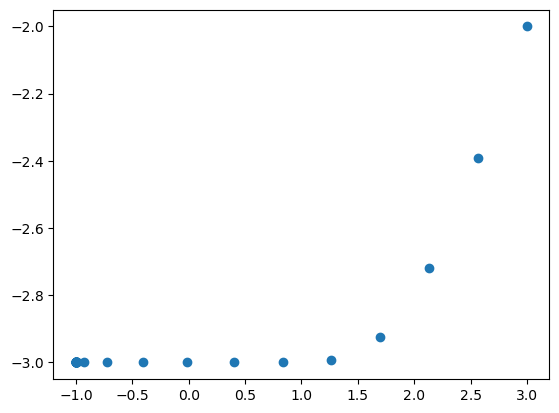

In [37]:
# positions = positions[5:]
# positions
plt.scatter([pos[0] for pos in positions],[ pos[1] for pos in positions])
plt.show()